Z-score Outlier Removal Weekly Statistics:
count    239268.000000
mean         -0.075618
std           4.280872
min         -99.031032
25%          -1.838235
50%           0.000000
75%           1.724138
max          98.412698
dtype: float64

MAD Outlier Removal Weekly Statistics:
count    238296.000000
mean         -0.130350
std           3.410124
min         -66.755319
25%          -1.485714
50%           0.000000
75%           1.257862
max          98.412698
dtype: float64

Mean ± 3 Standard Deviations Outlier Removal Weekly Statistics:
count    239425.000000
mean          0.086672
std           4.947621
min         -99.031032
25%          -1.956656
50%           0.000000
75%           2.040816
max         150.000000
dtype: float64

Initial Weekly Return Statistics:
count    239432.000000
mean          0.356596
std           6.886500
min         -93.661972
25%          -1.973684
50%           0.000000
75%           2.267230
max        1190.909091
dtype: float64

Data Point Counts:
I

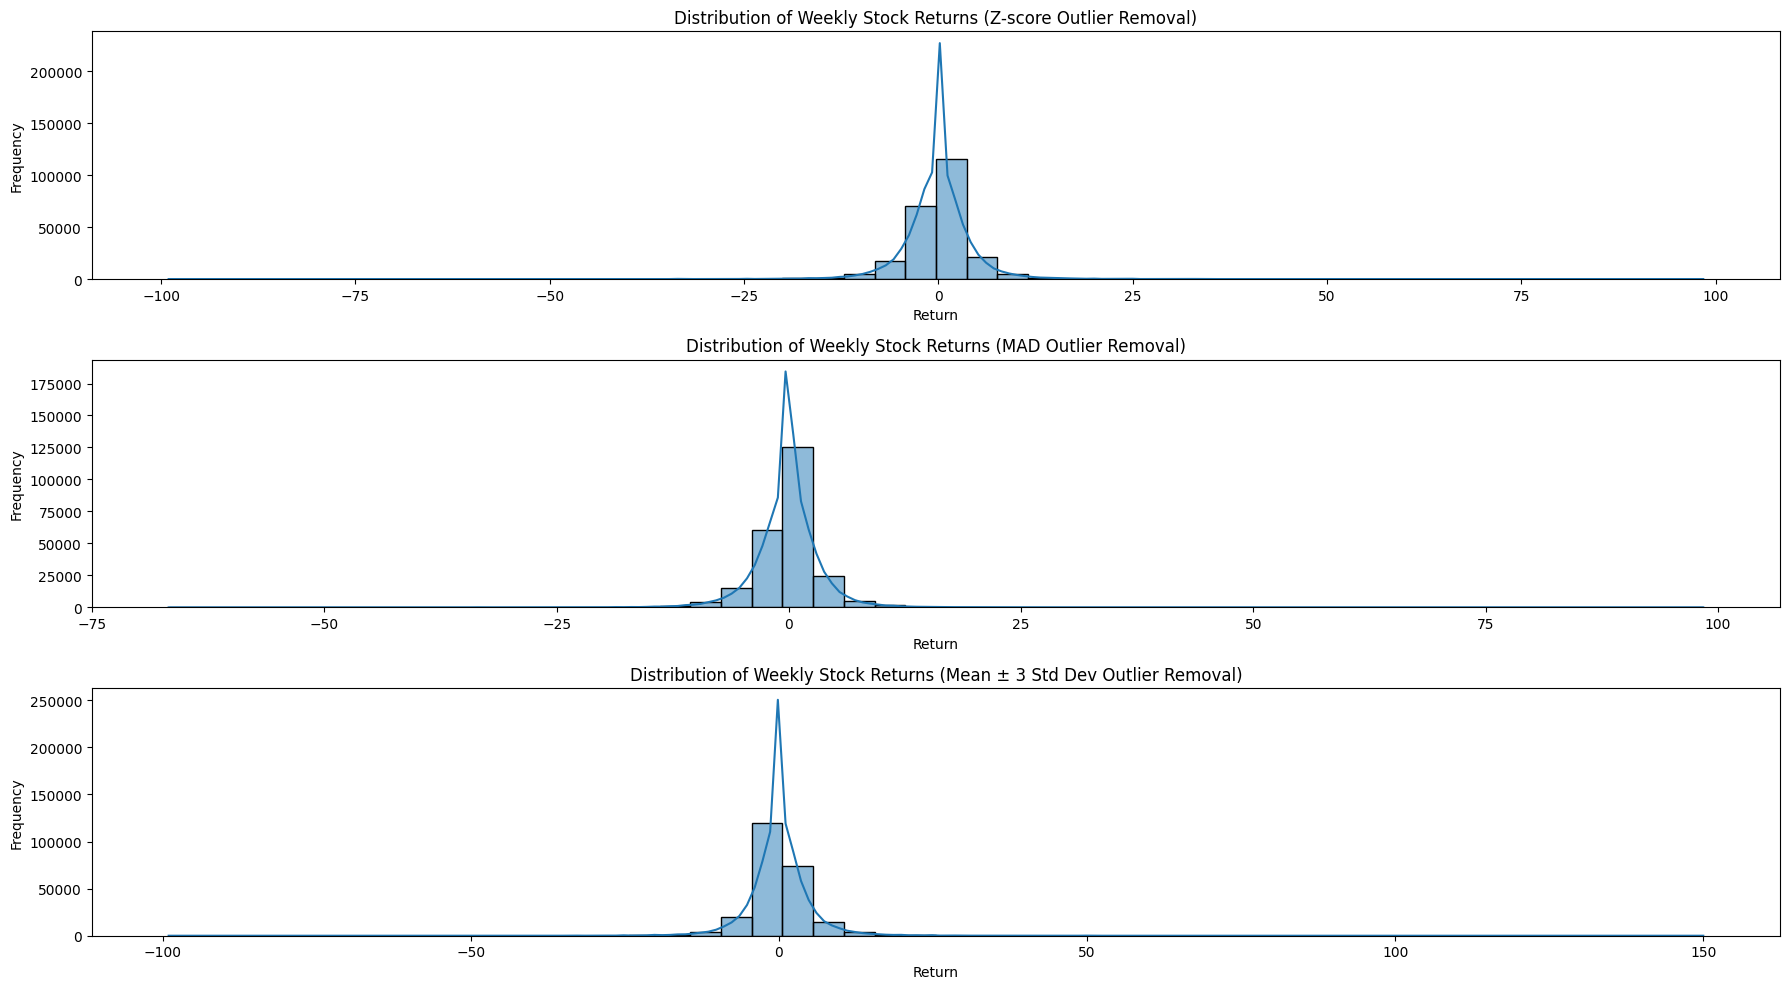

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
csv_file_path = '/Users/balmeru/Downloads/1989.csv' 
df = pd.read_csv(csv_file_path)

columns_to_check = ['ajexdi', 'prccd', 'trfd']
df.dropna(subset=columns_to_check, how='any', inplace=True)

date_format = '%Y-%m-%d'  
df['datadate'] = pd.to_datetime(df['datadate'], format=date_format)
df.sort_values(by=['tic', 'datadate'], inplace=True)

df['adjusted_close'] = df['prccd'] / df['ajexdi']
df['adjusted_close_prior'] = df.groupby('tic')['adjusted_close'].shift(1)
df['trfd_prior'] = df.groupby('tic')['trfd'].shift(1)

df['daily_return'] = (
    ((df['adjusted_close'] * df['trfd']) /
     (df['adjusted_close_prior'] * df['trfd_prior'])) - 1
) * 100

df['day_diff'] = df.groupby('tic')['datadate'].diff().dt.days 
df.loc[df['day_diff'] > 5, 'daily_return'] = np.nan

pivot_df = df.pivot_table(index='datadate', columns='tic', values='daily_return')

adjusted_daily_returns = pivot_df.map(lambda x: x / 100 + 1 if pd.notnull(x) else np.nan)

def consecutive_zeros(prices):
    count = 0
    max_count = 0
    for price in prices:
        if price == 0:
            count += 1
            max_count = max(max_count, count) 
        else:
            count = 0
    return max_count

consecutive_zero_counts = df.groupby('tic')['prccd'].apply(consecutive_zeros)

for ticker, max_zeros in consecutive_zero_counts.items():
    if max_zeros > 5:
        warnings.warn(f"Warning: Ticker '{ticker}' has more than 5 consecutive zeros in 'prccd'.")

# Method 1: Z-score outlier removal
mean = pivot_df.mean()
std_dev = pivot_df.std()
z_scores = (pivot_df - mean) / std_dev
threshold = 2
outliers_removed_df_z_scores = pivot_df[(abs(z_scores) <= threshold)]

# Method 2: MAD outlier removal
median_daily_return = pivot_df.median()
abs_deviations = np.abs(pivot_df - median_daily_return)
mad_daily_return = abs_deviations.median()
upper_bound_mad = median_daily_return + 3 * mad_daily_return
lower_bound_mad = median_daily_return - 3 * mad_daily_return
outliers_removed_df_mad = pivot_df[(pivot_df >= lower_bound_mad) & (pivot_df <= upper_bound_mad)]

# Method 3: Mean ± 3 standard deviations
lower_bound = mean - 3 * std_dev
upper_bound = mean + 3 * std_dev
outliers_removed_df_mean = pivot_df[(pivot_df >= lower_bound) & (pivot_df <= upper_bound)]

# Function to calculate weekly returns
def calculate_weekly_returns(outliers_removed_df):
    adjusted_daily_returns = outliers_removed_df.map(lambda x: x / 100 + 1 if pd.notnull(x) else np.nan)
    all_weekdays = pd.date_range(start=adjusted_daily_returns.index.min(), end=adjusted_daily_returns.index.max(), freq='B')  
    df_reindexed = adjusted_daily_returns.reindex(all_weekdays)
    all_mondays = pd.date_range(start=df_reindexed.index.min(), end=df_reindexed.index.max(), freq='W-MON')
    weekly_pivot_df = pd.DataFrame(data=np.nan, index=all_mondays, columns=df_reindexed.columns)
    ticker_start_dates = df_reindexed.apply(lambda x: x.first_valid_index(), axis=0)

    for i, monday in enumerate(all_mondays):
        start_date = monday
        if i < len(all_mondays) - 1:
            end_date = all_mondays[i + 1] - pd.DateOffset(days=1)
        else:
            end_date = df_reindexed.index.max()  # Last Monday
        
        weekly_data = df_reindexed.loc[start_date:end_date]
        for ticker in df_reindexed.columns:
            if monday < ticker_start_dates[ticker]:
                weekly_pivot_df.loc[monday, ticker] = np.nan
            else:
                if weekly_data.isnull().sum(axis=0)[ticker] == 5:
                    weekly_pivot_df.loc[monday, ticker] = np.nan
                else:
                    weekly_pivot_df.loc[monday, ticker] = (weekly_data[ticker].prod(skipna=True) - 1) * 100
    return weekly_pivot_df

# Calculate weekly returns for each method
weekly_pivot_df_mean = calculate_weekly_returns(outliers_removed_df_mean)
weekly_pivot_df_mad = calculate_weekly_returns(outliers_removed_df_mad)
weekly_pivot_df_z_scores = calculate_weekly_returns(outliers_removed_df_z_scores)
weekly_pivot_df_initial = calculate_weekly_returns(pivot_df)

# Get statistics for each method
weekly_mean_stats = weekly_pivot_df_mean.stack().describe()
weekly_mad_stats = weekly_pivot_df_mad.stack().describe()
weekly_z_scores_stats = weekly_pivot_df_z_scores.stack().describe()
weekly_initial_stats = weekly_pivot_df_initial.stack().describe()

# Print statistics for each method
print("Z-score Outlier Removal Weekly Statistics:")
print(weekly_z_scores_stats)
print("\nMAD Outlier Removal Weekly Statistics:")
print(weekly_mad_stats)
print("\nMean ± 3 Standard Deviations Outlier Removal Weekly Statistics:")
print(weekly_mean_stats)
print("\nInitial Weekly Return Statistics:")
print(weekly_initial_stats)

# Compare the count of non-null values
print("\nData Point Counts:")
print("Initial:", weekly_initial_stats['count'])
print("Z-score:", weekly_z_scores_stats['count'])
print("MAD:", weekly_mad_stats['count'])
print("Mean ± 3 Std Dev:", weekly_mean_stats['count'])

# Plot histograms of the weekly returns
plt.figure(figsize=(18, 10))

# Histogram for Z-score outlier removal
plt.subplot(3, 1, 1)
sns.histplot(weekly_pivot_df_z_scores.stack(), bins=50, kde=True)
plt.title('Distribution of Weekly Stock Returns (Z-score Outlier Removal)')
plt.xlabel('Return')
plt.ylabel('Frequency')

# Histogram for MAD outlier removal
plt.subplot(3, 1, 2)
sns.histplot(weekly_pivot_df_mad.stack(), bins=50, kde=True)
plt.title('Distribution of Weekly Stock Returns (MAD Outlier Removal)')
plt.xlabel('Return')
plt.ylabel('Frequency')

# Histogram for Mean ± 3 standard deviations outlier removal
plt.subplot(3, 1, 3)
sns.histplot(weekly_pivot_df_mean.stack(), bins=50, kde=True)
plt.title('Distribution of Weekly Stock Returns (Mean ± 3 Std Dev Outlier Removal)')
plt.xlabel('Return')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Z-score Outlier Removal Statistics:
count    1.102755e+06
mean    -7.387510e-03
std      2.442223e+00
min     -9.866670e+01
25%     -8.474576e-01
50%      0.000000e+00
75%      8.239495e-01
max      9.841270e+01
dtype: float64

MAD Outlier Removal Statistics:
count    1.028883e+06
mean    -2.394974e-02
std      2.028233e+00
min     -4.960000e+01
25%     -7.518797e-01
50%      0.000000e+00
75%      6.906077e-01
max      4.920635e+01
dtype: float64

Mean ± 3 Standard Deviations Outlier Removal Statistics:
count    1.145694e+06
mean     3.161101e-02
std      2.820366e+00
min     -9.866670e+01
25%     -9.009009e-01
50%      0.000000e+00
75%      9.090909e-01
max      9.841270e+01
dtype: float64

Initial Daily Return Statistics:
count    1.160858e+06
mean     1.032720e-01
std      8.222461e+00
min     -9.866670e+01
25%     -9.090909e-01
50%      0.000000e+00
75%      9.523810e-01
max      6.646032e+03
dtype: float64


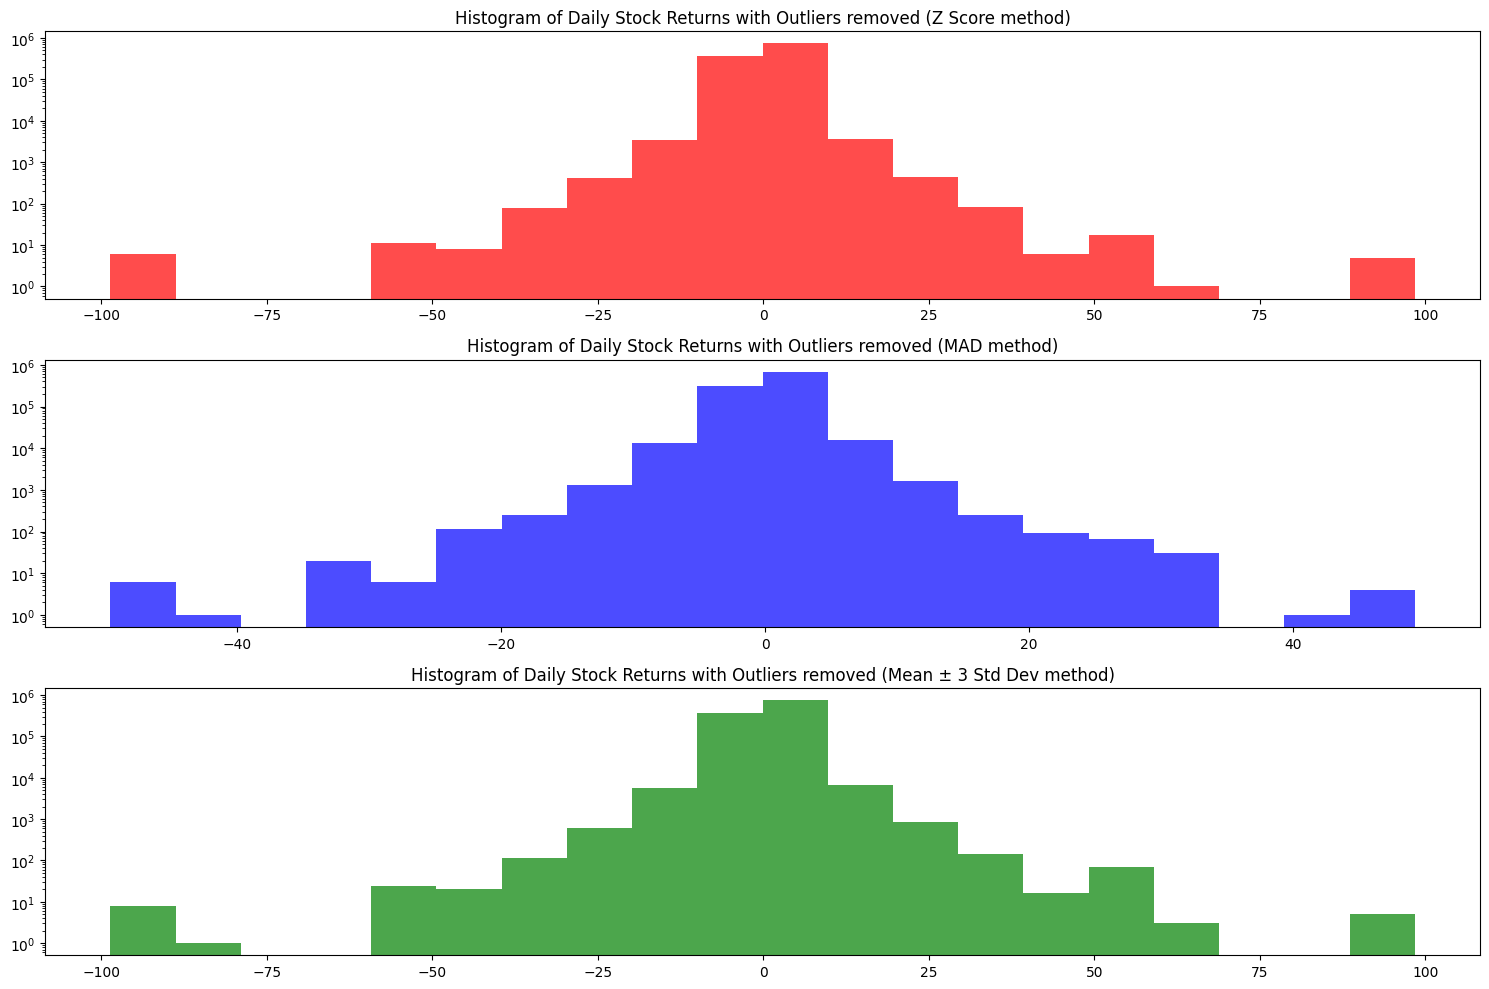

In [2]:
daily_returns_with_mean_stats = outliers_removed_df_mean.stack().describe()
daily_returns_with_mad_stats = outliers_removed_df_mad.stack().describe()
daily_returns_with_z_scores_stats = outliers_removed_df_z_scores.stack().describe()
initial_daily_stats = pivot_df.stack().describe()

# Print statistics for each method
print("Z-score Outlier Removal Statistics:")
print(daily_returns_with_z_scores_stats)
print("\nMAD Outlier Removal Statistics:")
print(daily_returns_with_mad_stats)
print("\nMean ± 3 Standard Deviations Outlier Removal Statistics:")
print(daily_returns_with_mean_stats)
print("\nInitial Daily Return Statistics:")
print(initial_daily_stats)

# Plot histograms for each method
plt.figure(figsize=(15, 10))

# Z-score method
plt.subplot(3, 1, 1)
plt.hist(outliers_removed_df_z_scores.stack().dropna(), bins=20, color='red', alpha=0.7)
plt.yscale('log')
plt.title('Histogram of Daily Stock Returns with Outliers removed (Z Score method)')

# MAD method
plt.subplot(3, 1, 2)
plt.hist(outliers_removed_df_mad.stack().dropna(), bins=20, color='blue', alpha=0.7)
plt.yscale('log')
plt.title('Histogram of Daily Stock Returns with Outliers removed (MAD method)')

# Mean ± 3 standard deviations method
plt.subplot(3, 1, 3)
plt.hist(outliers_removed_df_mean.stack().dropna(), bins=20, color='green', alpha=0.7)
plt.yscale('log')
plt.title('Histogram of Daily Stock Returns with Outliers removed (Mean ± 3 Std Dev method)')

plt.tight_layout()
plt.show()